In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Run this to attack a trained model via TrainModel. 
Use the "loadFullModel" submethod to load in an already trained model (trained via TrainModel)
The main attack function is "runAttacks" which runs attacks on trained models
"""
import warnings
warnings.filterwarnings("ignore")

import os
import tensorflow as tf
#tf.compat.v1.enable_eager_execution
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
from cleverhans.attacks import Noise, CarliniWagnerL2, MaxConfidence, FastGradientMethod, BasicIterativeMethod, DeepFool, MomentumIterativeMethod, ProjectedGradientDescent
from Model_Implementations import Model_Softmax_Baseline, Model_Logistic_Baseline, Model_Logistic_Ensemble, Model_Tanh_Ensemble, Model_Tanh_Baseline
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow.keras import backend
import numpy as np
import scipy.linalg
from scipy import stats
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
model_path = 'models/'  #path with saved model parameters 
sess =  backend.get_session()
backend.set_learning_phase(0) #need to do this to get CleverHans to work with batchnorm


#Dataset-specific parameters - should be same as those used in TrainModel
# DATA_DESC = 'CIFAR10'; (X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
# epochs=None; weight_save_freq=None
# num_classes=10  #how many classes (categories) are in this dataset?
# Y_train = np.squeeze(Y_train); Y_test = np.squeeze(Y_test)
# num_filters_std = [32, 64, 128]; num_filters_ens=[32, 64, 128]; num_filters_ens_2=16; dropout_rate_std=0.0; dropout_rate_ens=0.0; weight_decay = 0 
# model_rep_baseline=2; model_rep_ens=2; DATA_AUGMENTATION_FLAG=1; BATCH_NORMALIZATION_FLAG=1
# num_channels = 3; inp_shape = (32,32,3); lr=1e-4; batch_size=80;
# noise_stddev = 0.032; blend_factor = .032

#MNIST
DATA_DESC = 'MNIST'; (X_train, Y_train), (X_test, Y_test) = mnist.load_data()
Y_train = np.squeeze(Y_train); Y_test = np.squeeze(Y_test)
num_channels = 1; inp_shape = (28,28,1); num_classes=10
#MODEL-SPECIFIC PARAMETERS: MNIST
#PARAMETERS RELATED TO SGD OPTIMIZATION
epochs=None; weight_save_freq=None; batch_size=80; lr=3e-4; 
#MODEL DEFINTION PARAMETERS
num_filters_std = [64, 64, 64]; num_filters_ens=[32, 32, 32]; num_filters_ens_2=4; 
dropout_rate_std=0.0; dropout_rate_ens=0.0; weight_decay = 0 
noise_stddev = 0.3; blend_factor=0.3; 
model_rep_baseline=1; model_rep_ens=2; 
DATA_AUGMENTATION_FLAG=0; BATCH_NORMALIZATION_FLAG=0

#Attack parameters
eps_val = 8/255.0; PGD_iters = 200; eps_iter=(2/3)*eps_val; 
eps_range = np.linspace(0, 0.33, 10)
noise_eps=0.1


# DATA PRE-PROCESSING
X_train = (X_train/255).astype(np.float32);  X_test = (X_test/255).astype(np.float32)
#reshape (add third (image) channel)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2],num_channels); X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2],num_channels)
X_valid = X_test[1000:2000]; Y_valid = Y_test[1000:2000]; #validation data, used to attack model
X_train = X_train-0.5; X_test = X_test-0.5; X_valid = X_valid-0.5; #map to range (-0.5,0.5)
data_dict = {'X_train':X_train, 'Y_train_cat':Y_train, 'X_test':X_test, 'Y_test_cat':Y_test}
X_random = np.random.rand(X_valid.shape[0],X_valid.shape[1],X_valid.shape[2],X_valid.shape[3])-0.5; X_random = X_random.astype(np.float32)


# def output_activation(x):
#     return tf.nn.softmax(x) 

#Model definition of the model we want to attack; should be same as the definition used in TrainModel
name = 'logistic_baseline'+'_'+DATA_DESC; num_chunks=1
M = np.eye(num_classes).astype(np.float32)
def output_activation(x):
    return tf.nn.sigmoid(x)  
base_model=None
params_dict = {'weight_decay':weight_decay, 'num_filters_std':num_filters_std, 'BATCH_NORMALIZATION_FLAG':BATCH_NORMALIZATION_FLAG, 'DATA_AUGMENTATION_FLAG':DATA_AUGMENTATION_FLAG, 'M':M, 'model_rep':model_rep_baseline, 'base_model':base_model, 'num_chunks':num_chunks, 'output_activation':output_activation,  'batch_size':batch_size, 'epochs':epochs, 'lr':lr, 'dropout_rate':dropout_rate_std,  'blend_factor':blend_factor, 'inp_shape':inp_shape, 'noise_stddev':noise_stddev, 'weight_save_freq':weight_save_freq, 'name':name, 'model_path':model_path}
m4 = Model_Logistic_Baseline(data_dict, params_dict)
m4.loadFullModel() #load in the saved model, which should have already been trained first via TrainModel

m4.legend = 'TEns16'; 
m4.X_valid = X_valid; m4.Y_valid = Y_valid; 
m4.X_test = X_test; m4.Y_test = Y_test; 
m4.X_random = X_random; 
m4.minval = -0.5; m4.maxval = 0.5




def benignAccuracy(model, X, Y):
    
    acc_vec=[]; probs_benign_list=[]
    for rep in np.arange(0, X.shape[0], 1000):
        x = X[rep:rep+1000]
        probs_benign = sess.run(model.predict(tf.convert_to_tensor(x))) 
        acc= np.mean(np.argmax(probs_benign, 1)==Y[rep:rep+1000])
        acc_vec += [acc]
        probs_benign_list += list(np.max(probs_benign, 1))

        
    acc = np.mean(acc_vec)        
    print("Accuracy for model " + model.params_dict['name'] + " : ", acc)    
    return probs_benign_list


def wbAttack(model, attack, att_params, X, Y):
    sess =  backend.get_session()
    modelCH = model.modelCH()
    adv_model = attack(modelCH, sess=sess) 
    
    acc_vec=[]; probs_adv_list=[]
    inc=500
    for rep in np.arange(0, X.shape[0], inc):
        x = X[rep:rep+inc]
        y = Y[rep:rep+inc]
        X_adv = adv_model.generate(tf.convert_to_tensor(x), **att_params).eval(session=sess)   
        preds = np.argmax(sess.run(model.predict(tf.convert_to_tensor(X_adv))), 1)
        acc =  np.mean(np.equal(preds, y))
        probs_adv = np.max(sess.run(model.predict(tf.convert_to_tensor(X_adv))), 1)
        probs_adv = probs_adv[preds != y]
        acc= np.mean(np.equal(preds, y))
        acc_vec += [acc]
        probs_adv_list += list(probs_adv)

        
    acc = np.mean(acc_vec)        
    print("Adv accuracy for model " + model.params_dict['name'] + " : ", acc)    
    return probs_adv_list, acc, X_adv, y





def runAttacks(models_list):
    #CW attack
    for model in models_list:
        
        print(""); print(""); print("");
        print("Running tests on model: ", model.params_dict['name'])
        
#         print("Clean accuracy of model:")
#         probs_benign = benignAccuracy(model, model.X_test, model.Y_test)
#         print("")
        
        print("Running PGD attack:")
        att_params = {'clip_min': model.minval, 'clip_max':model.maxval, 'eps':eps_val, 'eps_iter':eps_iter, 'nb_iter':PGD_iters,'ord':np.inf}
        probs_adv_pgd, junk, X_adv_pgd, y_adv_pgd = wbAttack(model, ProjectedGradientDescent, att_params, model.X_valid, model.Y_valid)
        print("")
        
#         print("Running CW attack:")
#         att_params = {'clip_min': model.minval, 'clip_max':model.maxval,  'binary_search_steps':10, 'learning_rate':1e-3}
#         probs_adv_cw, junk, X_adv, y = wbAttack(model, CarliniWagnerL2, att_params, model.X_valid[0:100], model.Y_valid[0:100])
#         print("")
        
#         print("Running Blind Spot attack, alpha=0.8:")
#         att_params = {'clip_min': model.minval, 'clip_max':model.maxval,  'binary_search_steps':10, 'learning_rate':1e-3}
#         probs_adv_bsa, junk, X_adv, y = wbAttack(model, CarliniWagnerL2, att_params, 0.8*model.X_valid[0:100], model.Y_valid[0:100])
#         print("")
        
                
#         #Random ATTACK (0 SNR inputs)
#         print("Running random attack:")
#         probs_random = np.max(sess.run(model.predict(tf.convert_to_tensor(model.X_random))), 1)
#         print('Prob. that ', model.params_dict['name'], ' < 0.9 on random data: ', np.mean(probs_random<0.9))
        
#         #Noise ATTACK (low SNR inputs)
#         print("Running Noise attack:")
#         att_params = {'clip_min': model.minval, 'clip_max':model.maxval, 'eps':noise_eps}
#         probs_noise, junk, X_adv, y = wbAttack(model, Noise, att_params, model.X_valid, model.Y_valid)
#         print("")
        
#     return probs_benign, probs_adv_pgd, probs_adv_cw, probs_adv_bsa, probs_random, probs_noise, X_adv_pgd, y_adv_pgd
    return probs_adv_pgd, X_adv_pgd, y_adv_pgd #for plotting probs



models_list = [m4]
# probs_benign, probs_adv_pgd, probs_adv_cw, probs_adv_bsa, probs_random, probs_noise, X_adv_pgd, y_adv_pgd = runAttacks(models_list)

probs_adv_pgd,X_adv_pgd, y_adv_pgd = runAttacks(models_list) #for ploting probs



Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
gaussian_noise (GaussianNois (None, 28, 28, 1)         0         
_________________________________________________________________
lambda (Lambda)              (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        1664      
_________________________________________________________________
lwta__conv2d__activation (LW (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        36928     
______________________________________________

In [3]:
# np.save('plots_4/CIFAR/logistic_baseline_CIFAR/logistic_baseline_probs_benign.npy', probs_benign)
# np.save('plots_4/CIFAR/logistic_baseline_CIFAR/logistic_baseline_probs_adv_pgd.npy', probs_adv_pgd)
# np.save('plots_4/CIFAR/logistic_baseline_CIFAR/logistic_baseline_probs_adv_cw.npy', probs_adv_cw)
# np.save('plots_4/CIFAR/logistic_baseline_CIFAR/logistic_baseline_adv_bsa.npy', probs_adv_bsa)
# np.save('plots_4/CIFAR/logistic_baseline_CIFAR/logistic_baseline_probs_random.npy', probs_random)
# np.save('plots_4/CIFAR/logistic_baseline_CIFAR/logistic_baseline_probs_noise.npy', probs_noise)

In [4]:
# plt.figure(1)
# kernel = stats.gaussian_kde(probs_benign, bw_method=0.5)
# plt.plot(np.arange(0, 1, .01), kernel.pdf(np.arange(0, 1, .01)), linewidth=4)   

# plt.figure(2)
# kernel = stats.gaussian_kde(probs_adv_pgd, bw_method=0.5)
# plt.plot(np.arange(0, 1, .01), kernel.pdf(np.arange(0, 1, .01)), linewidth=4)   

# plt.figure(3)
# kernel = stats.gaussian_kde(probs_adv_cw, bw_method=0.5)
# plt.plot(np.arange(0, 1, .01), kernel.pdf(np.arange(0, 1, .01)), linewidth=4)   

# plt.figure(4)
# kernel = stats.gaussian_kde(probs_adv_bsa, bw_method=0.5)
# plt.plot(np.arange(0, 1, .01), kernel.pdf(np.arange(0, 1, .01)), linewidth=4)   

# plt.figure(5)
# kernel = stats.gaussian_kde(probs_random, bw_method=0.5)
# plt.plot(np.arange(0, 1, .01), kernel.pdf(np.arange(0, 1, .01)), linewidth=4)   

# plt.figure(6)
# kernel = stats.gaussian_kde(probs_noise, bw_method=0.5)
# plt.plot(np.arange(0, 1, .01), kernel.pdf(np.arange(0, 1, .01)), linewidth=4)   

In [20]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
import itertools
import numpy as np
import matplotlib.pyplot as plt

def transform_activations(C, U):
    acts_l1 = []
    
    for i in range(10):
        indices = np.where(y_adv_pgd==i)
        probabilities = m4.model_full.get_layer('lwta__dense__activation_2').output[1]
        intermediate_layer_model = Model(inputs=m4.model_full.input,outputs=probabilities)
        acts_1 = intermediate_layer_model.predict(X_adv_pgd)[1,:,:]
        
#         acts_1_mean = acts_1.mean(0)
        # take the max prob between the two units and assume that this is the one that fires
#         acts_1 = np.max(acts_1_mean, -1, keepdims=True)
#         acts_1 = acts_1_mean >= np.tile(acts_1_max, [1,U])
        acts_1 = np.reshape(acts_1, [-1])
        acts_l1.append(acts_1)
        
    return np.array(acts_l1)

activations = transform_activations(32, 2) #change C and U according to the model

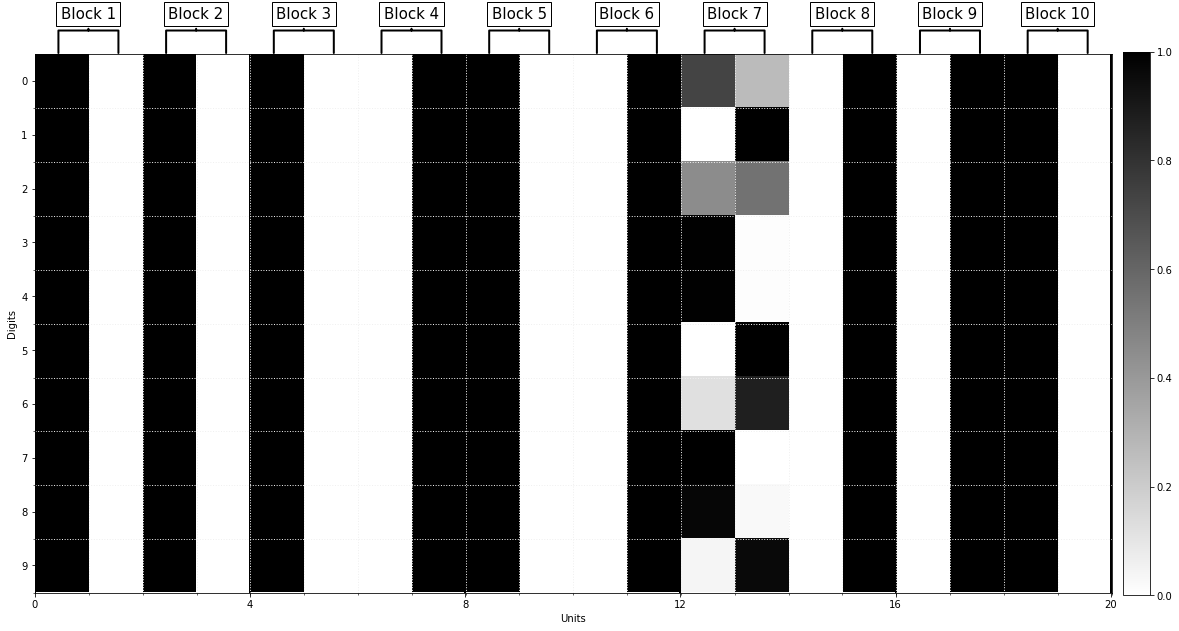

In [38]:
#for 4 Units

def plot_activations(activations, C, U):
    
    combs = []
    for i in range(C):
        for j in range(i, C):
            combs.append((i,j))
            
    a = list(range(C))
    b = list(range(C))
    combs_2 = list(itertools.product(a, b))
    
    if not os.path.exists('svg'):
        os.mkdir('svg')
        
    fig = plt.figure(figsize=(20,10))
    acts = activations[:,:20]
#     acts = np.expand_dims(acts, axis=1)
    ix = plt.imshow(acts, aspect='equal', cmap='binary')
    ax = plt.gca()
    size = acts.shape[-1]
    
    ax.set_xticks(np.arange(-.5, size, U))
    ax.set_yticks(np.arange(0,10,1))

    ax.set_xticklabels(np.arange(0,size+1, U))
    ax.set_yticklabels(np.arange(0,10,1))

    ax.set_xticks(np.arange(.51, size, 1), minor=True)
    ax.set_yticks(np.arange(.51, 10, 1), minor=True);


    ax.grid(which='minor', color=(240/255.,240./255,240/255.), linestyle=':', linewidth=1)
    ax.xaxis.grid(True,'major', color='black', linewidth=2)
    ax.yaxis.grid(True,'minor')
    
    ax.annotate('Block 1', xy=(0.05, 1.04), xytext=(0.05, 1.06), xycoords='axes fraction', 
            fontsize=15, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'),
            arrowprops=dict(arrowstyle='-[, widthB=2, lengthB=1.5', lw=2.0))

    ax.annotate('Block 2', xy=(0.15, 1.04), xytext=(0.15, 1.06), xycoords='axes fraction', 
            fontsize=15, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'),
            arrowprops=dict(arrowstyle='-[, widthB=2, lengthB=1.5', lw=2.0))
    
    ax.annotate('Block 3', xy=(0.25, 1.04), xytext=(0.25, 1.06), xycoords='axes fraction', 
        fontsize=15, ha='center', va='bottom',
        bbox=dict(boxstyle='square', fc='white'),
        arrowprops=dict(arrowstyle='-[, widthB=2, lengthB=1.5', lw=2.0))
    
    ax.annotate('Block 4', xy=(0.35, 1.04), xytext=(0.35, 1.06), xycoords='axes fraction', 
        fontsize=15, ha='center', va='bottom',
        bbox=dict(boxstyle='square', fc='white'),
        arrowprops=dict(arrowstyle='-[, widthB=2, lengthB=1.5', lw=2.0))
    
    ax.annotate('Block 5', xy=(0.45, 1.04), xytext=(0.45, 1.06), xycoords='axes fraction', 
        fontsize=15, ha='center', va='bottom',
        bbox=dict(boxstyle='square', fc='white'),
        arrowprops=dict(arrowstyle='-[, widthB=2, lengthB=1.5', lw=2.0))
    
    ax.annotate('Block 6', xy=(0.55, 1.04), xytext=(0.55, 1.06), xycoords='axes fraction', 
        fontsize=15, ha='center', va='bottom',
        bbox=dict(boxstyle='square', fc='white'),
        arrowprops=dict(arrowstyle='-[, widthB=2, lengthB=1.5', lw=2.0))
    
    ax.annotate('Block 7', xy=(0.65, 1.04), xytext=(0.65, 1.06), xycoords='axes fraction', 
        fontsize=15, ha='center', va='bottom',
        bbox=dict(boxstyle='square', fc='white'),
        arrowprops=dict(arrowstyle='-[, widthB=2, lengthB=1.5', lw=2.0))
    
    ax.annotate('Block 8', xy=(0.75, 1.04), xytext=(0.75, 1.06), xycoords='axes fraction', 
        fontsize=15, ha='center', va='bottom',
        bbox=dict(boxstyle='square', fc='white'),
        arrowprops=dict(arrowstyle='-[, widthB=2, lengthB=1.5', lw=2.0))
    
    ax.annotate('Block 9', xy=(0.85, 1.04), xytext=(0.85, 1.06), xycoords='axes fraction', 
        fontsize=15, ha='center', va='bottom',
        bbox=dict(boxstyle='square', fc='white'),
        arrowprops=dict(arrowstyle='-[, widthB=2, lengthB=1.5', lw=2.0))
    
    ax.annotate('Block 10', xy=(0.95, 1.04), xytext=(0.95, 1.06), xycoords='axes fraction', 
        fontsize=15, ha='center', va='bottom',
        bbox=dict(boxstyle='square', fc='white'),
        arrowprops=dict(arrowstyle='-[, widthB=2, lengthB=1.5', lw=2.0))

    plt.xlabel('Units')
    plt.ylabel('Digits')
    
    plt.colorbar(fraction=0.025, pad=0.01)
    plt.clim(0, 1);
 
#     plt.show()
    plt.savefig('svg/lwta_U_2.svg', format='svg', dpi=1200)
        #tikz_save(path+'tikz\\layer_'+str(i)+'all_digits.tex',  figureheight='20cm', figurewidth='20cm')
#     plt.close(fig)

plot_activations(activations=activations, C=16, U=4)

In [8]:
# #for 4 Units

# def plot_activations(activations, C, U):
    
#     combs = []
#     for i in range(C):
#         for j in range(i, C):
#             combs.append((i,j))
            
#     a = list(range(C))
#     b = list(range(C))
#     combs_2 = list(itertools.product(a, b))
    
#     if not os.path.exists('svg'):
#         os.mkdir('svg')
        
#     fig = plt.figure(figsize=(20,10))
#     acts = activations
# #     acts = np.expand_dims(acts, axis=1)
#     ix = plt.imshow(acts, aspect='equal', cmap='binary')
#     ax = plt.gca()
#     size = acts.shape[-1]
    
#     ax.set_xticks(np.arange(-.5, size, U))
#     ax.set_yticks(np.arange(0,10,1))

#     ax.set_xticklabels(np.arange(0,size+1, U))
#     ax.set_yticklabels(np.arange(0,10,1))

#     ax.set_xticks(np.arange(.51, size, 1), minor=True)
#     ax.set_yticks(np.arange(.51, 10, 1), minor=True);


#     ax.grid(which='minor', color=(240/255.,240./255,240/255.), linestyle=':', linewidth=1)
#     ax.xaxis.grid(True,'major', color='black', linewidth=2)
#     ax.yaxis.grid(True,'minor')
    
#     ax.annotate('Block 1', xy=(0.032, 1.1), xytext=(0.032, 1.15), xycoords='axes fraction', 
#             fontsize=10, ha='center', va='bottom',
#             bbox=dict(boxstyle='square', fc='white'),
#             arrowprops=dict(arrowstyle='-[, widthB=2.5, lengthB=1.5', lw=2.0))

#     ax.annotate('Block 2', xy=(0.095, 1.1), xytext=(0.095, 1.15), xycoords='axes fraction', 
#             fontsize=10, ha='center', va='bottom',
#             bbox=dict(boxstyle='square', fc='white'),
#             arrowprops=dict(arrowstyle='-[, widthB=2.5, lengthB=1.5', lw=2.0))

#     ax.annotate('Block 3', xy=(0.154, 1.1), xytext=(0.154, 1.15), xycoords='axes fraction', 
#             fontsize=10, ha='center', va='bottom',
#             bbox=dict(boxstyle='square', fc='white'),
#             arrowprops=dict(arrowstyle='-[, widthB=2.5, lengthB=1.5', lw=2.0))
    
#     ax.annotate('Block 4', xy=(0.217, 1.1), xytext=(0.217, 1.15), xycoords='axes fraction', 
#             fontsize=10, ha='center', va='bottom',
#             bbox=dict(boxstyle='square', fc='white'),
#             arrowprops=dict(arrowstyle='-[, widthB=2.5, lengthB=1.5', lw=2.0))
    
#     ax.annotate('Block 5', xy=(0.280, 1.1), xytext=(0.280, 1.15), xycoords='axes fraction', 
#             fontsize=10, ha='center', va='bottom',
#             bbox=dict(boxstyle='square', fc='white'),
#             arrowprops=dict(arrowstyle='-[, widthB=2.5, lengthB=1.5', lw=2.0))
    
#     ax.annotate('Block 6', xy=(0.343, 1.1), xytext=(0.343, 1.15), xycoords='axes fraction', 
#             fontsize=10, ha='center', va='bottom',
#             bbox=dict(boxstyle='square', fc='white'),
#             arrowprops=dict(arrowstyle='-[, widthB=2.5, lengthB=1.5', lw=2.0))
    
#     ax.annotate('Block 7', xy=(0.406, 1.1), xytext=(0.406, 1.15), xycoords='axes fraction', 
#             fontsize=10, ha='center', va='bottom',
#             bbox=dict(boxstyle='square', fc='white'),
#             arrowprops=dict(arrowstyle='-[, widthB=2.5, lengthB=1.5', lw=2.0))
    
#     ax.annotate('Block 8', xy=(0.469, 1.1), xytext=(0.469, 1.15), xycoords='axes fraction', 
#             fontsize=10, ha='center', va='bottom',
#             bbox=dict(boxstyle='square', fc='white'),
#             arrowprops=dict(arrowstyle='-[, widthB=2.5, lengthB=1.5', lw=2.0))
    
#     ax.annotate('Block 9', xy=(0.532, 1.1), xytext=(0.532, 1.15), xycoords='axes fraction', 
#             fontsize=10, ha='center', va='bottom',
#             bbox=dict(boxstyle='square', fc='white'),
#             arrowprops=dict(arrowstyle='-[, widthB=2.5, lengthB=1.5', lw=2.0))
    
#     ax.annotate('Block 10', xy=(0.594, 1.1), xytext=(0.594, 1.15), xycoords='axes fraction', 
#             fontsize=10, ha='center', va='bottom',
#             bbox=dict(boxstyle='square', fc='white'),
#             arrowprops=dict(arrowstyle='-[, widthB=2.5, lengthB=1.5', lw=2.0))
    
#     ax.annotate('Block 11', xy=(0.656, 1.1), xytext=(0.656, 1.15), xycoords='axes fraction', 
#             fontsize=10, ha='center', va='bottom',
#             bbox=dict(boxstyle='square', fc='white'),
#             arrowprops=dict(arrowstyle='-[, widthB=2.5, lengthB=1.5', lw=2.0))
    
#     ax.annotate('Block 12', xy=(0.725, 1.1), xytext=(0.725, 1.15), xycoords='axes fraction', 
#             fontsize=10, ha='center', va='bottom',
#             bbox=dict(boxstyle='square', fc='white'),
#             arrowprops=dict(arrowstyle='-[, widthB=2.5, lengthB=1.5', lw=2.0))
    
#     ax.annotate('Block 13', xy=(0.778, 1.1), xytext=(0.778, 1.15), xycoords='axes fraction', 
#             fontsize=10, ha='center', va='bottom',
#             bbox=dict(boxstyle='square', fc='white'),
#             arrowprops=dict(arrowstyle='-[, widthB=2.5, lengthB=1.5', lw=2.0))
    
#     ax.annotate('Block 14', xy=(0.841, 1.1), xytext=(0.841, 1.15), xycoords='axes fraction', 
#             fontsize=10, ha='center', va='bottom',
#             bbox=dict(boxstyle='square', fc='white'),
#             arrowprops=dict(arrowstyle='-[, widthB=2.5, lengthB=1.5', lw=2.0))
    
#     ax.annotate('Block 15', xy=(0.904, 1.1), xytext=(0.904, 1.15), xycoords='axes fraction', 
#             fontsize=10, ha='center', va='bottom',
#             bbox=dict(boxstyle='square', fc='white'),
#             arrowprops=dict(arrowstyle='-[, widthB=2.5, lengthB=1.5', lw=2.0))
    
#     ax.annotate('Block 16', xy=(0.967, 1.1), xytext=(0.967, 1.15), xycoords='axes fraction', 
#             fontsize=10, ha='center', va='bottom',
#             bbox=dict(boxstyle='square', fc='white'),
#             arrowprops=dict(arrowstyle='-[, widthB=2.5, lengthB=1.5', lw=2.0))

#     plt.xlabel('Units')
#     plt.ylabel('Digits')
    
#     plt.colorbar(fraction=0.0078, pad=0.01)
#     plt.clim(0, 1);
 
# #     plt.show()
#     plt.savefig('svg/lwta_U_4.svg', format='svg', dpi=1200)
#         #tikz_save(path+'tikz\\layer_'+str(i)+'all_digits.tex',  figureheight='20cm', figurewidth='20cm')
# #     plt.close(fig)

# plot_activations(activations=activations, C=16, U=4)